# 使用 `shard_map` 进行手动并行处理

<!--* freshness: { reviewed: '2024-04-08' } *-->

## 概述

`shard_map` 是一个单程序多数据（SPMD）多设备并行处理 API，用于在数据分片上映射函数。映射的函数应用或 _实例_ 通过显式的集体通信操作进行相互通信。

`shard_map` 是与内置于 `jit` 中的自动编译器并行化互补的并且可以组合使用的工具。使用 `jit`，您可以像为单个设备编写代码一样编写代码，[编译器可以自动将计算划分到多个设备上](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html)，在后台生成每个设备的代码和通信集合。使用 `shard_map`，您可以掌控权利，自行编写分区代码和显式集合。或者，您也可以做到两者兼而有之：在设备组之间手动控制，同时将组内设备的分区留给编译器。两种方法可以根据需要进行混合、匹配和组合。

如果您熟悉 `pmap`，可以将 `shard_map` 视为一种进化。它更具表达能力、性能更佳，并且与其他 JAX API 更具可组合性。它甚至可以以急切模式工作，便于调试！ （更多内容，请参见 [与 `pmap` 的详细比较。](https://jax.readthedocs.io/en/latest/jep/14273-shard-map.html#why-don-t-pmap-or-xmap-already-solve-this)）

通过阅读本教程，您将了解到如何使用 `shard_map` 来完全控制多设备代码。您将详细看到它如何与 `jax.jit` 的自动并行化和 `jax.grad` 的自动微分组合使用。我们还将给出一些神经网络并行化策略的基本示例。

我们假设本教程正在一个具有八个设备的环境中运行：


In [ ]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8' # 使用8个CPU设备


### 那么，让我们看看一个 `shard_map`！

不再拖延，这里是一个玩具示例：


In [ ]:
from functools import partial

import jax
import jax.numpy as jnp

from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental import mesh_utils
from jax.experimental.shard_map import shard_map


In [ ]:
devices = mesh_utils.create_device_mesh((4, 2))
mesh = Mesh(devices, axis_names=('x', 'y'))

a = jnp.arange( 8 * 16.).reshape(8, 16)
b = jnp.arange(16 *  4.).reshape(16, 4)

@partial(shard_map, mesh=mesh, in_specs=(P('x', 'y'), P('y', None)),
         out_specs=P('x', None))
def matmul_basic(a_block, b_block):
  # a_block: f32[2, 8]
  # b_block: f32[8, 4]
  c_partialsum = jnp.dot(a_block, b_block)
  c_block = jax.lax.psum(c_partialsum, 'y')
  # c_block: f32[2, 4]
  return c_block

c = matmul_basic(a, b)   # c: f32[8, 4]


这个函数通过执行局部块矩阵乘法并随后进行集合求和操作，在并行中计算矩阵乘法。我们可以检查结果是否正确：


In [ ]:
from jax.tree_util import tree_map, tree_all

def allclose(a, b):
  return tree_all(tree_map(partial(jnp.allclose, atol=1e-2, rtol=1e-2), a, b))

allclose(c, jnp.dot(a, b))


结果沿着其行进行分片：


In [ ]:
jax.debug.visualize_array_sharding(c)


从高层次来看，`shard_map` 有点像 `vmap` 或 `pmap`，因为我们正在对数组数据的片段映射一个函数，但请注意：
* `shard_map` 将输入切分成块（输出通过连接结果块形成），保持相同的秩，而 `vmap` 会通过映射掉一个轴来降低秩；
* `mesh` 参数让我们控制计算和结果的准确设备位置；
* 我们同时在多个数据轴上进行映射，并为集合设置多个轴名称（这里是 `'x'` 和 `'y'`）；
* 由于我们还没有使用 `jax.jit`，所有内容都是即时计算的，我们甚至可以 `print` 中间值以便调试。

上述代码执行的计算与此 `jax.jit` 自动并行化代码相同：


In [ ]:
from jax.sharding import NamedSharding

a = jax.device_put(a, NamedSharding(mesh, P('x', 'y')))
b = jax.device_put(b, NamedSharding(mesh, P('y', None)))

@jax.jit
def matmul_reference(a, b):
  c = jnp.dot(a, b)
  return jax.lax.with_sharding_constraint(c, NamedSharding(mesh, P('x', None)))

c_ref = matmul_reference(a, b)
allclose(c_ref, jnp.dot(a, b))


我们可以将 `shard_map` 理解为根据其 `mesh` 和 `in_specs` 参数对输入执行 `device_put` 或 `with_sharding_constraint`，因此 `matmul_basic` 操作的块与 `matmul_reference` 中的一致：


In [ ]:
print('a blocks:'); jax.debug.visualize_array_sharding(a)
print('b blocks:'); jax.debug.visualize_array_sharding(b)
print('c blocks:'); jax.debug.visualize_array_sharding(c)


### 放慢脚步，从基础开始！

#### 降秩映射与保秩映射

我们可以将 `vmap` 和 `pmap` 看作是在某个轴上将每个数组输入进行展开（例如，将一个二维矩阵展开为它的二维行），将其主体函数应用于每个部分，然后将结果重新堆叠在一起，至少在没有涉及集体操作的情况下：


In [ ]:
def check_vmap(f, xs):
  ans = jax.vmap(f, in_axes=(0,), out_axes=0)(xs)
  expected = jnp.stack([f(x) for x in xs])  # vmap引用语义
  print(allclose(ans, expected))

check_vmap(lambda x: x @ x, jnp.arange(12).reshape(4, 3))


例如，如果 `xs` 的形状为 `f32[8,5]`，那么每个 `x` 的形状将为 `f32[5]`，并且如果每个 `f(x)` 的形状为 `f32[3,7]`，那么最终堆叠的结果 `vmap(f)(xs)` 将具有形状 `f32[8,3,7]`。也就是说，主体函数 `f` 的每次调用的输入参数比 `vmap(f)` 的对应参数少一个轴。我们可以说这些是_降低秩的映射_，具有输入/输出的解叠/堆叠行为。

`f` 的逻辑应用数量，或 `f` 的_实例_，由正在映射的输入轴的大小决定：例如，如果我们在一个大小为 8 的输入轴上进行映射，从语义上讲，我们获得 8 次对该函数的逻辑应用。

相比之下，`shard_map` 并没有这种降低秩的行为。相反，我们可以将其视为沿输入轴切片（或“解串联”）成块，应用主体函数，然后将结果重新拼接在一起（同样在没有集体操作时）：


In [ ]:
import numpy as np
devices = np.array(jax.devices()[:4])
mesh = Mesh(devices, ('i',))  # mesh.shape['i'] = 4

def check_shmap(f, y):
  ans = shard_map(f, mesh, in_specs=P('i'), out_specs=P('i'))(y)
  expected = jnp.concatenate([f(y_blk) for y_blk in jnp.split(y, mesh.shape['i'])])
  print(allclose(ans, expected))

check_shmap(lambda x: x.T @ x, jnp.arange(32).reshape(8, 4))


请回忆一下，`jnp.split`将其输入切分为大小相等的块，保持相同的秩，因此如果在上述示例中`y`的形状为`f32[8,5]`，那么每个`y_blk`的形状将为`f32[2,5]`，如果每个`f(y_blk)`的形状为`f32[3,7]`，那么最终拼接的结果`shard_map(f, ...)(y)`将具有形状`f32[12,7]`。因此，`shard_map`在其输入的_碎片_或块上进行映射。我们可以称它为一种_保持秩的映射_，在其输入/输出的非拼接/拼接之间进行。

`f`的逻辑应用数量由网格大小决定，而不是由任何输入轴大小决定。例如，如果我们有一个总大小为4的网格（即在4个设备上），那么从语义上讲，我们得到4个函数的逻辑应用，这对应于物理上计算这些函数的4个设备。

#### 使用`in_specs`控制每个输入的切分（非拼接）和平铺

每个`in_specs`通过使用`PartitionSpec`以名称的方式识别某些相应输入数组的轴与网格轴的对应关系，表示如何将该输入切分（或非拼接）为应用于主体函数的块。该识别决定了碎片大小；当一个输入轴与一个网格轴关联时，输入沿着该逻辑轴被切分（非拼接）为对应的网格轴大小相等的多个部分。（如果对应的网格轴大小不能均匀地整除输入数组轴大小，则会发生错误。）如果输入的pspec没有提及网格轴名称，则不会在该网格轴上进行切分。例如：


In [ ]:
devices = mesh_utils.create_device_mesh((4, 2))
mesh = Mesh(devices, ('i', 'j'))

@partial(shard_map, mesh=mesh, in_specs=P('i', None), out_specs=P('i', 'j'))
def f1(x_block):
  print(x_block.shape)  # 打印（3, 12）
  return x_block

x1 = jnp.arange(12 * 12).reshape(12, 12)
y = f1(x1)


在这里，由于输入的 pspec 中没有提到网格轴名称 `'j'`，因此输入数组的轴并未在该网格轴上拆分；同样，由于输入数组的第二个轴没有与任何网格轴对应（因此也没有在其上拆分），因此应用 `f1` 时可以沿该轴完整地查看输入。

当输入 pspec 中未提及某个网格轴时，我们总可以重写为一个效率较低的程序，其中提到了所有的网格轴，但调用者执行 `jnp.tile`，例如：


In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P('i', 'j'), out_specs=P('i', 'j'))
def f2(x_block):
  print(x_block.shape)
  return x_block

x = jnp.arange(12 * 12).reshape(12, 12)
x_ = jnp.tile(x, (1, mesh.shape['j']))  # x 的形状为 (12, 24)
y = f2(x_)  # 打印 (3,12)，并且 f1(x) == f2(x_)


换句话说，由于每个输入的 pspec 可以零次或一次提及每个网格轴名称，而不必确切提及每个名称一次，我们可以说除了内置于输入中的 `jnp.split` 之外，`shard_map` 逻辑上也包含一个内置于输入中的 `jnp.tile`（尽管实际的平铺可能不需要执行，这取决于参数的物理分片布局）。使用的平铺并不是唯一的；我们还可以沿着第一个轴进行平铺，并使用 pspec `P(('j', 'i'), None)`。

物理数据移动可以在输入上进行，因为每个设备需要拥有相应数据的副本。

#### 控制如何通过连接、块转置和撤销平铺来组装每个输出，使用 `out_specs`

类似于输入端，每个 `out_specs` 通过名称将相应输出数组的一些轴与网格轴关联，表示输出块（每次应用主体函数一个，或者等效于每个物理设备一个）应如何重新组装在一起以形成最终输出值。例如，在上述 `f1` 和 `f2` 示例中，`out_specs` 指示我们应通过沿两个轴连接块结果来形成最终输出，结果在这两种情况下数组 `y` 的形状为 `(12, 24)`。（如果主体函数的输出形状，即输出块的形状，对于所描述的相应输出 pspec 的连接而言，其秩太小，将会导致错误。）

当输出 pspec 中未提及网格轴名称时，表示未平铺：当用户编写的输出 pspec 未提及某个网格轴名称时，他们承诺输出块在该网格轴上是相等的，因此在输出中只使用沿该轴的一个块（而不是沿该网格轴连接所有块）。例如，使用与上述相同的网格：


In [ ]:
x = jnp.array([[3.]])

z = shard_map(lambda: x, mesh=mesh, in_specs=(), out_specs=P('i', 'j'))()
print(z)  # 输出与 jnp.tile(x, (4, 2)) 相同

z = shard_map(lambda: x, mesh=mesh, in_specs=(), out_specs=P('i', None))()
print(z)  # 输出与 jnp.tile(x, (4, 1)) 相同，或者简化为 jnp.tile(x, (4,))

z = shard_map(lambda: x, mesh=mesh, in_specs=(), out_specs=P(None, None))()
print(z)  # 与 jnp.tile(x, (1, 1)) 输出相同，即直接输出 x


函数体闭合一个数组值等价于将其作为一个增强参数传递，具有相应的输入规范 P(None, None)。作为另一个例子，更加紧密地跟随上述其他例子：


In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P('i', 'j'), out_specs=P('i', None))
def f3(x_block):
  return jax.lax.psum(x_block, 'j')

x = jnp.arange(12 * 12).reshape(12, 12)
y3 = f3(x)
print(y3.shape)


结果的第二个轴大小为6，为输入的第二个轴的一半。在这种情况下，由于集体操作`psum`，未在输出pspec中提及网格轴名称`'j'`是安全的，因为这确保了每个输出块在相应的网格轴上是相等的。以下是两个更多的示例，其中我们改变了在输出pspec中提及的网格轴：


In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P('i', 'j'), out_specs=P(None, 'j'))
def f4(x_block):
  return jax.lax.psum(x_block, 'i')

x = jnp.arange(12 * 12).reshape(12, 12)
y4 = f4(x)
print(y4.shape)  # （3,12）


@partial(shard_map, mesh=mesh, in_specs=P('i', 'j'), out_specs=P(None, None))
def f5(x_block):
  return jax.lax.psum(x_block, ('i', 'j'))

y5 = f5(x)
print(y5.shape)  # （3,6）


```markdown
在物理方面，在输出 pspec 中不提及网格轴名称会在该网格轴上沿着复制布局的输出设备缓冲区组装一个 `Array`。

没有运行时检查输出块在要取消瓷砖的网格轴上是否实际相等，或者对应的物理缓冲区是否具有相等的值，因此可以被解释为单个逻辑数组的复制布局。但是我们可以提供一种静态检查机制，可以对所有潜在不正确的程序引发错误。

因为 `out_specs` 可以提及网格轴名称零次或一次，并且可以按任意顺序提及，我们可以说，除了内置于其输出中的 `jnp.concatenate`，`shard_map` 还在其输出中实现了一个 _untile_ 和一个 _block transpose_。

物理数据在输出上是不可能移动的，无论输出 pspec 如何。相反，`out_specs` 仅编码如何将块输出组装成 `Array`，或者在物理上如何解释跨设备的缓冲区作为单个逻辑 `Array` 的物理布局。

## API 规范

```python
from jax.sharding import Mesh
Specs = PyTree[PartitionSpec]

def shard_map(
    f: Callable, mesh: Mesh, in_specs: Specs, out_specs: Specs,
    auto: collections.abc.Set[AxisName] = frozenset([]),
    check_rep: bool = True,
) -> Callable:
  ...
```
其中：
* 在 `f` 的主体中，像 `psum` 这样的通信集体可以提及 `mesh` 的轴名称；
* `mesh` 编码设备以数组形式排列，并具有关联的轴名称，就像它对 `sharding.NamedSharding` 所做的那样；
* `in_specs` 和 `out_specs` 是 `PartitionSpec`，可以类比地提及来自 `mesh` 的轴名称，以分别表达输入和输出的切片/取消拼接和拼接，而未提及的名称对应于复制和取消瓷砖（assert-replicated-so-give-me-one-copy）；
* `auto` 是一个可选的轴名称集合，对应于 `mesh` 的子集，方便在调用者中自动处理，而不是手动处理；
* `check_rep` 是一个可选的布尔值，指示是否静态检查 `out_specs` 中的任何复制错误，同时是否启用相关的自动微分优化（参见 [JEP](https://jax.readthedocs.io/en/latest/jep/17111-shmap-transpose.html)）。

传递给 `f` 的参数的形状与 `shard_map`-of-`f` 的参数具有相同的等级，而 `f` 的参数形状是从相应的 `shard_map`-of-`f` 的形状 `shape` 和相应的 `PartitionSpec` `spec` 计算出来，近似为 `tuple(sz // (1 if n is None else mesh.shape[n]) for sz, n in zip(shape, spec))`。

## 集体教程

`shard_map` 不一定是一个纯映射：函数应用可以通过 _collectives_ 彼此通信，使用 `mesh` 参数中定义的轴名称。

回想一下，`shard_map` 将函数在输入数据的碎片或块上进行映射，因此这样：

```python
mesh = Mesh(jax.devices(), ('i',))
x = jnp.arange(16.)
f_shmapped = shard_map(f, mesh, in_specs=P('i'), out_specs=P('i'))
y = f_shmapped(x)
```

计算的值与这个参考函数相同，对相同参数值评估 `f` 的应用：

```python
def f_shmapped_ref(x):
  x_blocks = jnp.array_split(x, mesh.shape['i'])
  y_blocks = [f(x_blk) for x_blk in x_blocks]
  return jnp.concatenate(y_blocks)
```

我们称这些应用 `f` 对不同参数碎片的应用为 _function instances_。每个函数实例在不同设备（或设备子集）上执行。

这些参考语义在 `f` 中没有通信集体时有效。但是，如果我们希望函数实例之间进行通信，这对应于跨设备通信怎么办？也就是说，当 `f` 包含集体时，参考语义是什么？假设 `f` 只有一个集体，并且形式如下：

```python
def f(x_blk):
  z_blk = f_part1(x_blk)
  u_blk = collective(z_blk, axis_name)
  v_blk = f_part2(x_blk, z_blk, u_blk)
  return v_blk
```

我们假设只有一个我们正在映射的网格轴，并且 `axis_name` 是相应的名称。那么参考语义将看起来更像：

```python
def f_shmapped_ref(x):
  x_blocks = jnp.array_split(x, mesh.shape[0])
  z_blocks = [f_part1(x_blk) for x_blk in x_blocks]
  u_blocks = [collective_ref(i, z_blocks) for i in range(len(z_blocks))]
  v_blocks = [f_part2(x_blk, z_blk, u_blk) for x_blk, z_blk, u_blk
              in zip(x_blocks, z_blocks, u_blocks)]
  return jnp.concatenate(v_blocks)
```

注意，`collective_ref` 可能依赖于所有的 `z_blocks`。也就是说，虽然 `f_part1` 和 `f_part2` 是独立地作用于块，但是一个集体引入了一定的跨块依赖性。物理上，这意味着跨设备通信。到底发生了什么通信，以及计算了什么值，取决于集体。

### `psum`

最简单的集体可能是 `jax.lax.psum`，它沿着设备网格轴（或多个轴）计算全局归约和。
这里有一个玩具示例：
```
```
```


In [ ]:
import jax
import jax.numpy as jnp
from jax import lax

from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.experimental.shard_map import shard_map


In [ ]:
mesh1d = Mesh(jax.devices()[:4], ('i',))

@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P(None))
def f1(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.psum(x_block, 'i')
  print('AFTER:\n', y_block)
  return y_block


In [ ]:
x = jnp.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 1, 2])
y = f1(x)
print('FINAL RESULT:\n', y)


打印结果表明，每个函数应用都以其自己的参数值 `x_block` 开始。在 `psum` 之后，每个函数应用拥有相同的 `y_block` 值，该值是通过将应用的 `x_block` 值相加而计算得到的。

在计算中只有一个轴名称的情况下，我们可以说 `psum` 的 `collective_ref` 参考实现为：

```python
def psum_ref(_, x_blocks):
  tot = sum(x_blocks)
  return [tot] * len(x_blocks)
```

还要注意，由于 `f1` 返回 `y_block`，即在 `'i'` 上进行 `psum` 的结果，我们可以使用 `out_specs=P()`，这样调用者将获得结果值的单个逻辑副本，而不是一个平铺的结果。

当有多个网格轴时，我们可以分别对每个轴进行 `psum`，或者同时对多个轴进行 `psum`：


In [ ]:
mesh2d = Mesh(np.array(jax.devices()[:4]).reshape(2, 2), ('i', 'j'))

@partial(shard_map, mesh=mesh2d, in_specs=P('i', 'j'), out_specs=P(None, 'j'))
def f2(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.psum(x_block, 'i')
  print('AFTER:\n', y_block)
  return y_block

y = f2(jnp.arange(16).reshape(4, 4))
print('FINAL RESULT:\n', y)


通过在网格轴 `'i'` 上应用 `psum`，我们得到在轴 `'i'` 上相等但在轴 `'j'` 上不相等的 `y_block` 值。（所以我们可以使用 `out_specs=P(None, 'j')` 来获得该轴上的单一逻辑结果。）

如果我们在两个轴上都应用 `psum`，则 `y_block` 值在两个轴上都是相等的：


In [ ]:
@partial(shard_map, mesh=mesh2d, in_specs=P('i', 'j'), out_specs=P(None, None))
def f3(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.psum(x_block, ('i', 'j'))
  print('AFTER:\n', y_block)
  return y_block

y = f3(jnp.arange(16).reshape(4, 4))
print('FINAL RESULT:\n', y)


In machine learning, we often use `psum` to compute total losses or, when we
have a `grad` inside the `shard_map`ped function body, total gradients.

In the sequel, we'll see how `psum` can be implemented in terms of other
primitives, which gives some intuition about its communication cost.

### `all_gather`

Another fundamental operation is gathering array shards along an axis, so that
each function application has a full copy of the data along that axis:

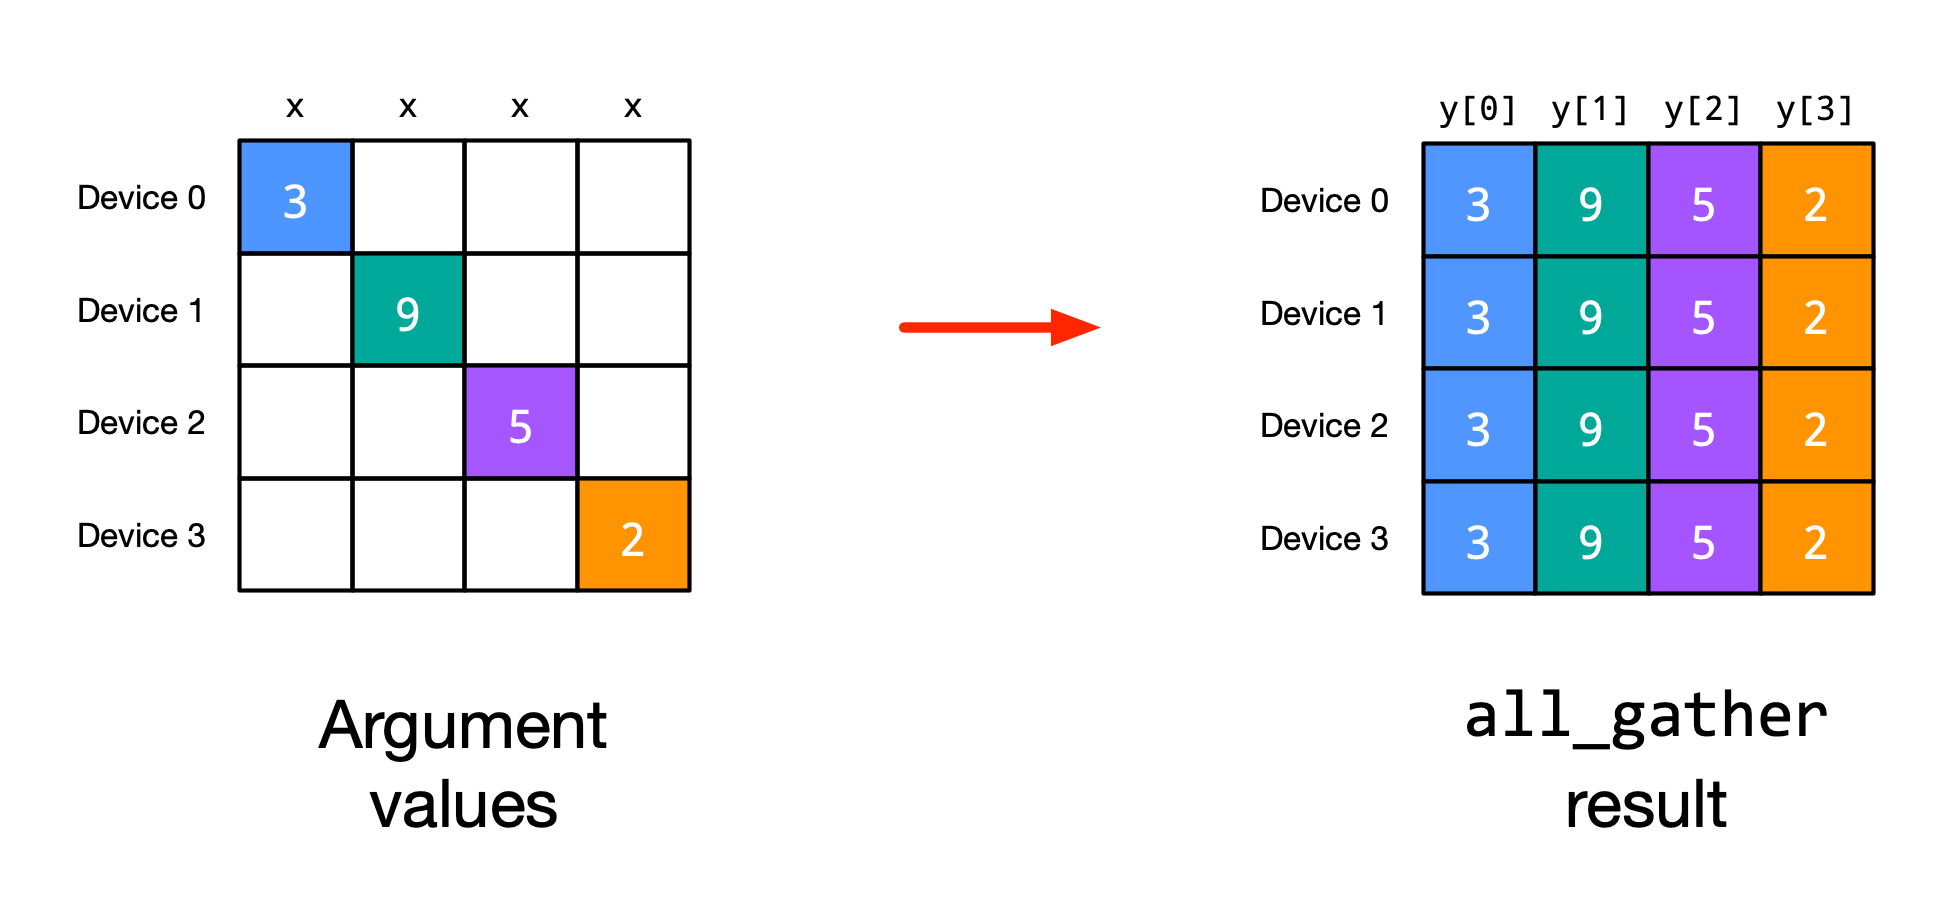


In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f4(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.all_gather(x_block, 'i', tiled=True)
  print('AFTER:\n', y_block)
  return y_block

x = jnp.array([3, 9, 5, 2])
y = f4(x)
print('FINAL RESULT:\n', y)


打印结果显示每个函数应用程序仍然以自己的参数值 `x_block` 开始。在 `all_gather` 之后，它们有一个公共值，通过拼接 `x_block` 的值计算而来。

（注意，我们实际上不能在这里设置 `out_specs=P()`。由于与自动微分相关的技术原因，我们认为 `all_gather` 的输出在不同设备之间并不能保证不变。如果我们希望保证不变，可以使用 `jax.lax.all_gather_invariant`，或者在这种情况下我们可以避免在函数体中执行 `all_gather`，而是使用 `out_specs=P('i')` 来进行拼接。）

当 `tiled=False`（默认值）时，结果沿着一个新轴堆叠，而不是拼接：


In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f5(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.all_gather(x_block, 'i', tiled=False)
  print('AFTER:\n', y_block)
  return y_block

y = f5(x)
print('FINAL RESULT:\n', y)


我们可以为 `all_gather` 编写 `collective_ref` 引用语义函数，如下所示：

```python
def all_gather_ref(_, x_blocks, *, tiled=False):
  combine = jnp.concatenate if tiled else jnp.stack
  return [combine(x_blocks)] * len(x_blocks)
```

在深度学习中，我们可能会在完全分片的数据并行性（FSDP）中对参数使用 `all_gather`。

### `psum_scatter`

`jax.lax.psum_scatter` 集合的语义稍微不那么直观。它类似于 `psum`，但每个函数实例只获得结果的一片：

<img alt="psum_scatter 计算的示意图。" src="


In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f6(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.psum_scatter(x_block, 'i', tiled=True)
  print('AFTER:\n', y_block)
  return y_block

x = jnp.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 1, 2])
y = f6(x)
print('FINAL RESULT:\n', y)


如打印所示，每个结果 `y_block` 的大小都小于参数 `x_block`，与 `psum` 不同。此外，与 `psum` 相比，这里的每个 `y_block` 仅代表跨功能实例的 `x_block` 的和的一个切片。（即使每个功能实例仅获得和的一个分片，最终输出 `y` 与 `psum` 示例中的相同，因为这里我们使用 `out_specs=P('i')` 来连接每个功能实例的输出。）

就计算的值而言，一个 `collective_ref` 参考实现可能看起来如下：

```python
def psum_scatter_ref(i, x_blocks, *, tiled=False):
  axis_size = len(x_blocks)
  tot = sum(x_blocks)
  if tiled:
    tot = tot.reshape(axis_size, -1, *tot.shape[1:])  # 拆分主轴
  return [tot[i] for i in range(tot.shape[0])]
```

在语义参考实现中没有捕捉到，但 `psum_scatter` 是有用的，因为这些结果的计算效率更高，通信量更少，而不是完全的 `psum`。实际上，可以将 `psum_scatter` 理解为“`psum` 的前半部分，在进行 `all_gather` 之前”。也就是说，实现 `psum` 的一种方法是：

```python
def psum(x, axis_name):
  summed_chunk = jax.lax.psum_scatter(x, axis_name)
  return jax.lax.all_gather(summed_chunk, axis_name)
```

实际上，这种实现通常在 TPU 和 GPU 上使用！

`psum_scatter` 所需的通信量约为完全 `psum` 的一半的原因在于 `ppermute` 部分中进行了说明。

另一个直观的理解是，我们可以使用 `psum_scatter` 来实现一个在相同轴上分片的分布式矩阵乘法。在机器学习中，`psum_scatter` 可以用于张量并行矩阵乘法或完全分片的数据并行梯度累积，如下面的示例所示。

### `ppermute`

`jax.lax.ppermute` 集体提供了功能实例之间互相发送数据的最直接方式。给定一个网格轴和一组表示沿该网格轴的 `(source_index, destination_index)` 对的列表，`ppermute` 将其参数值从每个源功能实例发送到每个目标：


In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f7(x_block):
  sz = jax.lax.psum(1, 'i')
  print('BEFORE:\n', x_block)
  y_block = jax.lax.ppermute(x_block, 'i', [(i, (i + 1) % sz) for i in range(sz)])
  print('AFTER:\n', y_block)
  return y_block

y = f7(jnp.arange(8))
print('FINAL RESULT:\n', y)


In this case, with just two function instances, each instance's value of
`y_block` is the other's value of `x_block`.

Source indices and destination indices can't be repeated. If an index does not
appear as a destination, then the value of the corresponding function
instance's result is an array of zeros.

A `collective_ref` reference implementation could look like

```python
def ppermute_ref(i, x_blocks, perm):
  results = [jnp.zeros_like(x_blocks[0])] * len(x_blocks)
  for src, dst in perm:
    results[dst] = x_blocks[src]
  return results
```

Other collectives can be implemented efficiently, in terms of total
communication, using `ppermute`s where each function passes data only to its
neighbors. For example, we could implement `psum_scatter` using a sequence of
`ppermute`s and local additions this way:

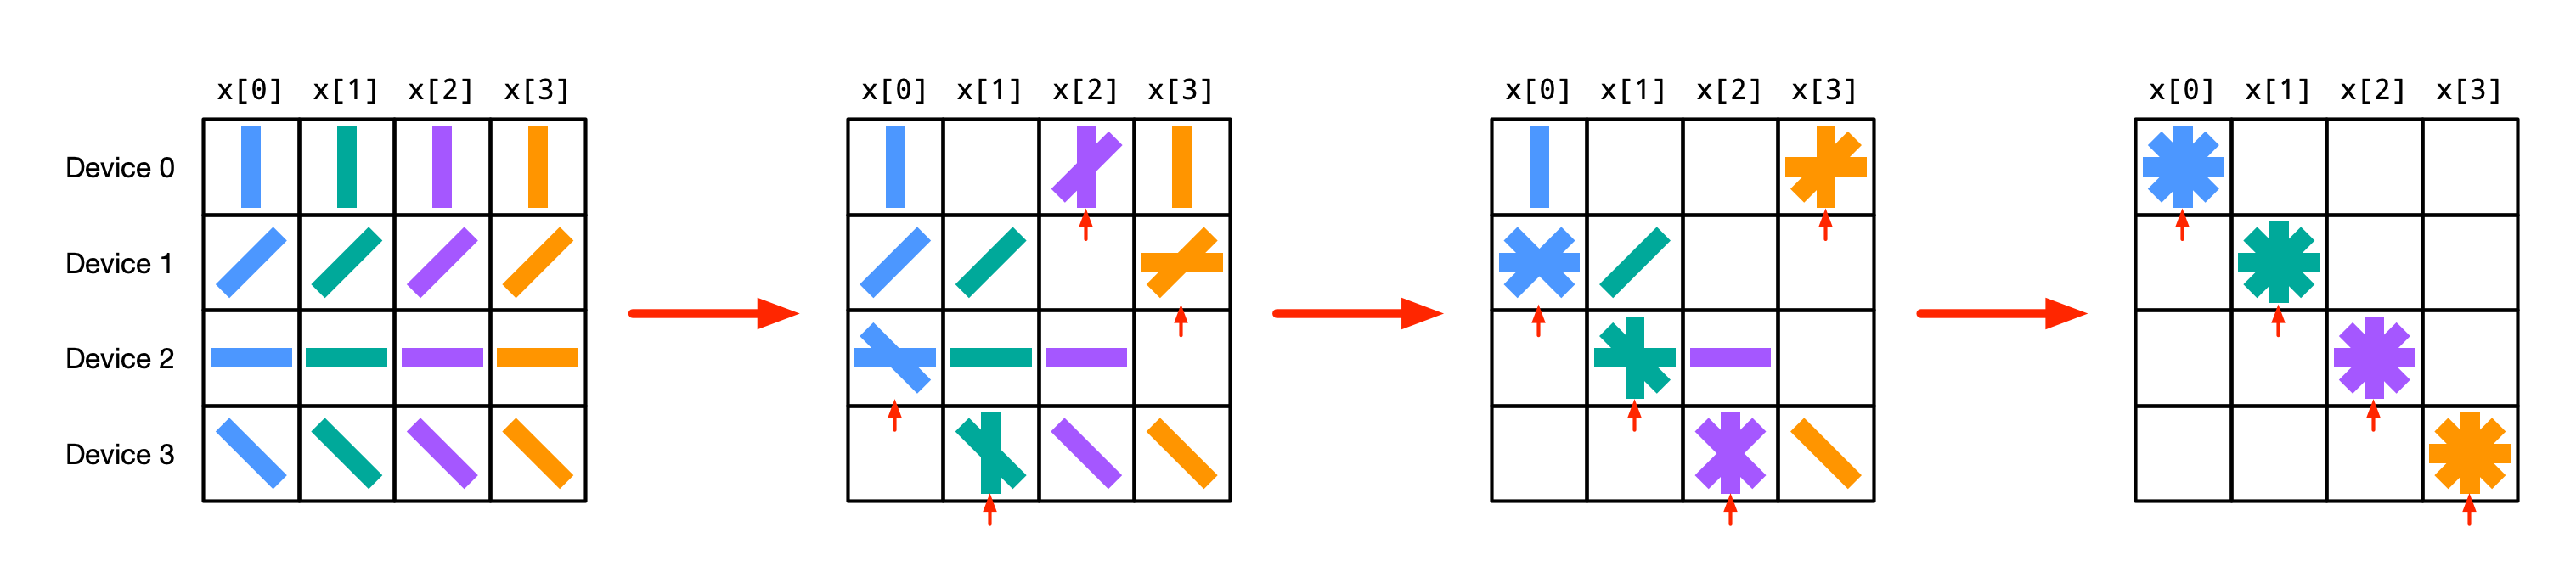

Or, with a numerical example:

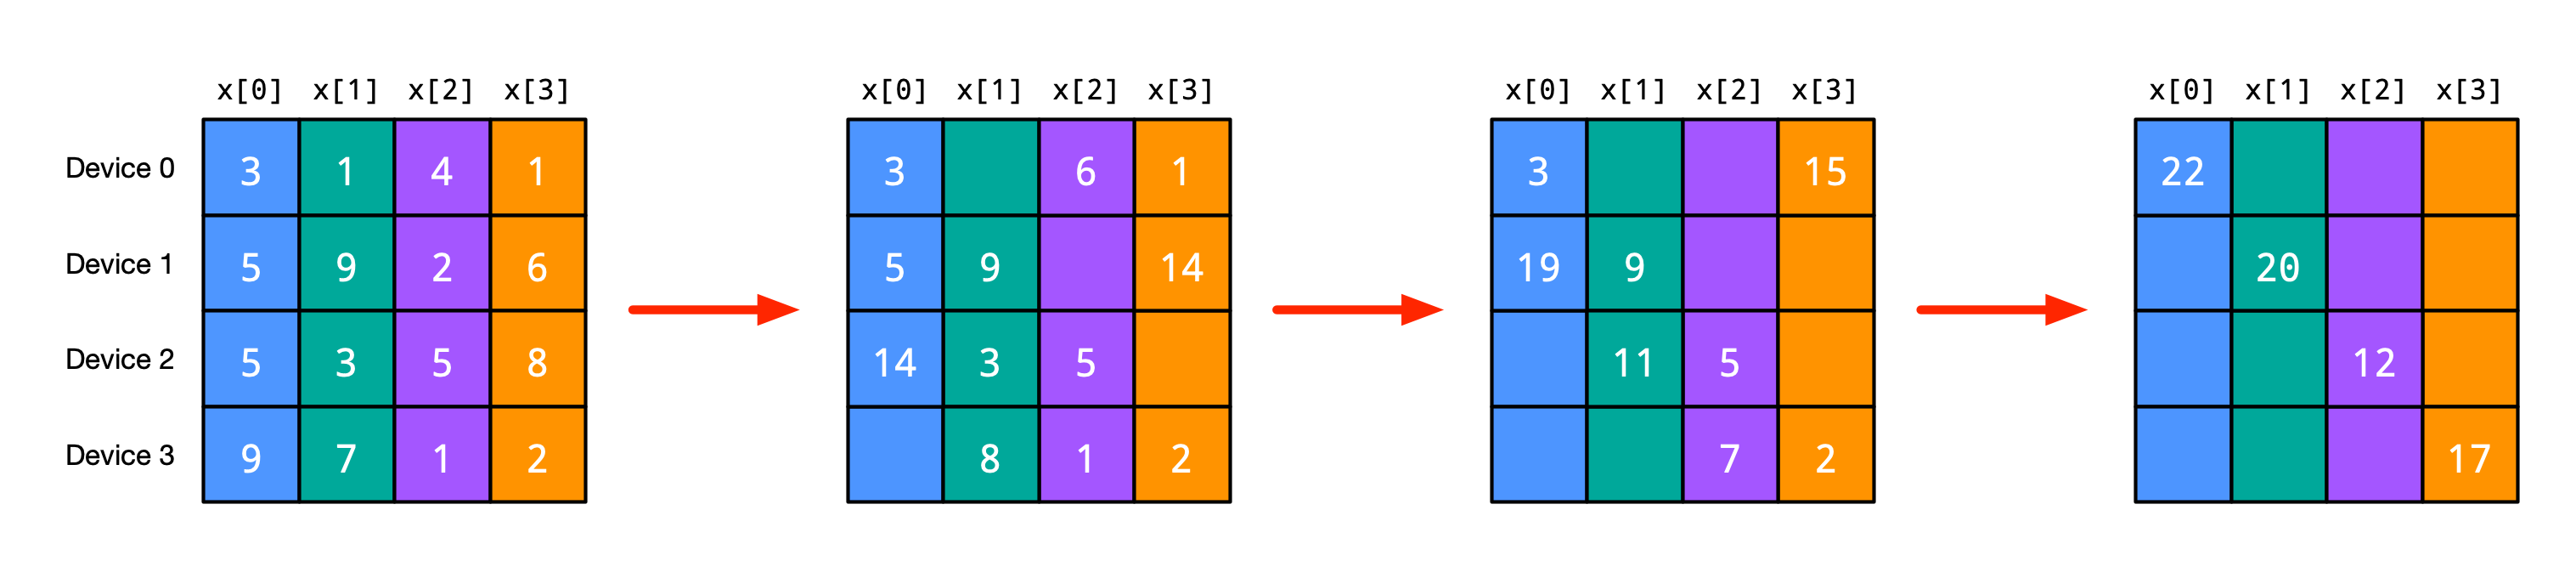


Intuitively, on each iteration each function instance sends 'up' the value it
received on the previous iteration, and reduces (adds) the value it receives
this iteration. In code, it might look like this:


In [ ]:
def psum_scatter(x, axis_name, *, tiled=False):
  size = jax.lax.psum(1, axis_name)
  idx = jax.lax.axis_index(axis_name)  # 沿轴名索引的函数实例
  if tiled:
    x = x.reshape(size, -1, *x.shape[1:])  # 分割主导轴
  shift = partial(jax.lax.ppermute, axis_name=axis_name,
                  perm=[(i, (i - 1) % size) for i in range(size)])
  for i in range(1, size):
    update = shift(x[(idx + i) % size])
    x = x.at[(idx + i + 1) % size].add(update)
  return x[idx]


In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f8(x_block):
  print('BEFORE:\n', x_block)
  y_block = psum_scatter(x_block, 'i', tiled=True)
  print('AFTER:\n', y_block)
  return y_block

x = jnp.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 1, 2])
y = f8(x)
print('FINAL RESULT:\n', y)


在TPU上，有这个算法的高维变体，以利用多个双向物理网格轴。

请注意，`psum_scatter` 是 `all_gather` 的转置。实际上，可以通过 `ppermute` 来实现 `all_gather`，这看起来像是上述过程的反向过程：

<img alt="all_gather 实现示意图。" src="


In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f9(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.all_to_all(x_block, 'i', split_axis=0, concat_axis=0,
                               tiled=True)
  print('AFTER:\n', y_block)
  return y_block

x = jnp.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 1, 2])
y = f9(x)
print('FINAL RESULT:\n', y)


`split_axis` 参数指示应该在哪个位置轴上进行分片和跨网格轴的分区。`concat_axis` 参数指示通信结果应沿哪个轴进行连接或堆叠。

当 `tiled=False` （默认值）时，`split_axis` 轴的大小必须等于名为 `axis_name` 的网格轴的大小，并且在 `concat_axis` 位置创建一个该大小的新轴用于堆叠结果。当 `tiled=True` 时，`split_axis` 轴的大小只需能够被网格轴的大小整除，结果沿现有轴 `concat_axis` 进行连接。

当 `split_axis=0` 和 `concat_axis=0` 时，`collective_ref` 的引用语义可能如下所示：

```python
def all_to_all_ref(_, x_blocks, *, tiled=False):
  axis_size = len(x_blocks)
  if tiled:
    splits = [jnp.array_split(x, axis_size) for x in x_blocks]
    return [jnp.concatenate(s) for s in zip(*splits)]
  else:
    splits = [list(x) for x in x_blocks]
    return [jnp.stack(s) for s in zip(*splits)]
```

在深度学习中，我们可能会在专家混合路由中使用 `all_to_all`，我们首先根据样本应该去哪个专家对本地批次的示例进行排序，然后应用 `all_to_all` 将示例重新分配给专家。

## 例子

我们如何在实际中使用 `shard_map` 和集体通信？这些例子虽然简单，但能给出一些思路。

### 矩阵乘法

并行化矩阵乘法是扩展深度学习模型的关键，无论是用于训练还是推理。当 `jax.jit` 自动并行化矩阵乘法时，它可以根据矩阵的大小、硬件细节和其他因素使用几种不同的策略。我们如何更明确地利用 `shard_map` 编写这些并行化例程？我们又如何优化它们以获得更好的计算/通信重叠，从而提高 FLOP 利用率？


In [ ]:
import jax
import jax.numpy as jnp

from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.experimental.shard_map import shard_map


In [ ]:
mesh = Mesh(jax.devices()[:4], ('i',))

def device_put(x, pspec):
  return jax.device_put(x, NamedSharding(mesh, pspec))


#### 示例 1: 一侧的 `all-gather`

考虑执行矩阵乘法，我们在其主（非收缩）维度上对左侧参数进行分片：


In [ ]:
lhs_spec = P('i', None)
lhs = device_put(jax.random.normal(jax.random.key(0), (8, 8)), lhs_spec)


我们在其收缩维度上对右侧参数（可以认为是激活）进行分片，同时对输出进行类似的分片：


In [ ]:
rhs_spec = P('i', None)
rhs = device_put(jax.random.normal(jax.random.key(1), (8, 4)), rhs_spec)


要执行此矩阵乘法，我们可以首先对右侧进行全收集，然后对分片的左侧执行局部矩阵乘法：


In [ ]:
@jax.jit
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_allgather(lhs_block, rhs_block):
  rhs = jax.lax.all_gather(rhs_block, 'i', tiled=True)
  return lhs_block @ rhs


In [ ]:
out = matmul_allgather(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))


That's great, but we're not getting any compute/communication overlap
here: before we can start the matmul, we need the `all_gather` to complete.
Here's a profile using the same code, but on larger example shapes (`(8192,
8192)` for `lhs` and `(8192, 1024)` for `rhs`):

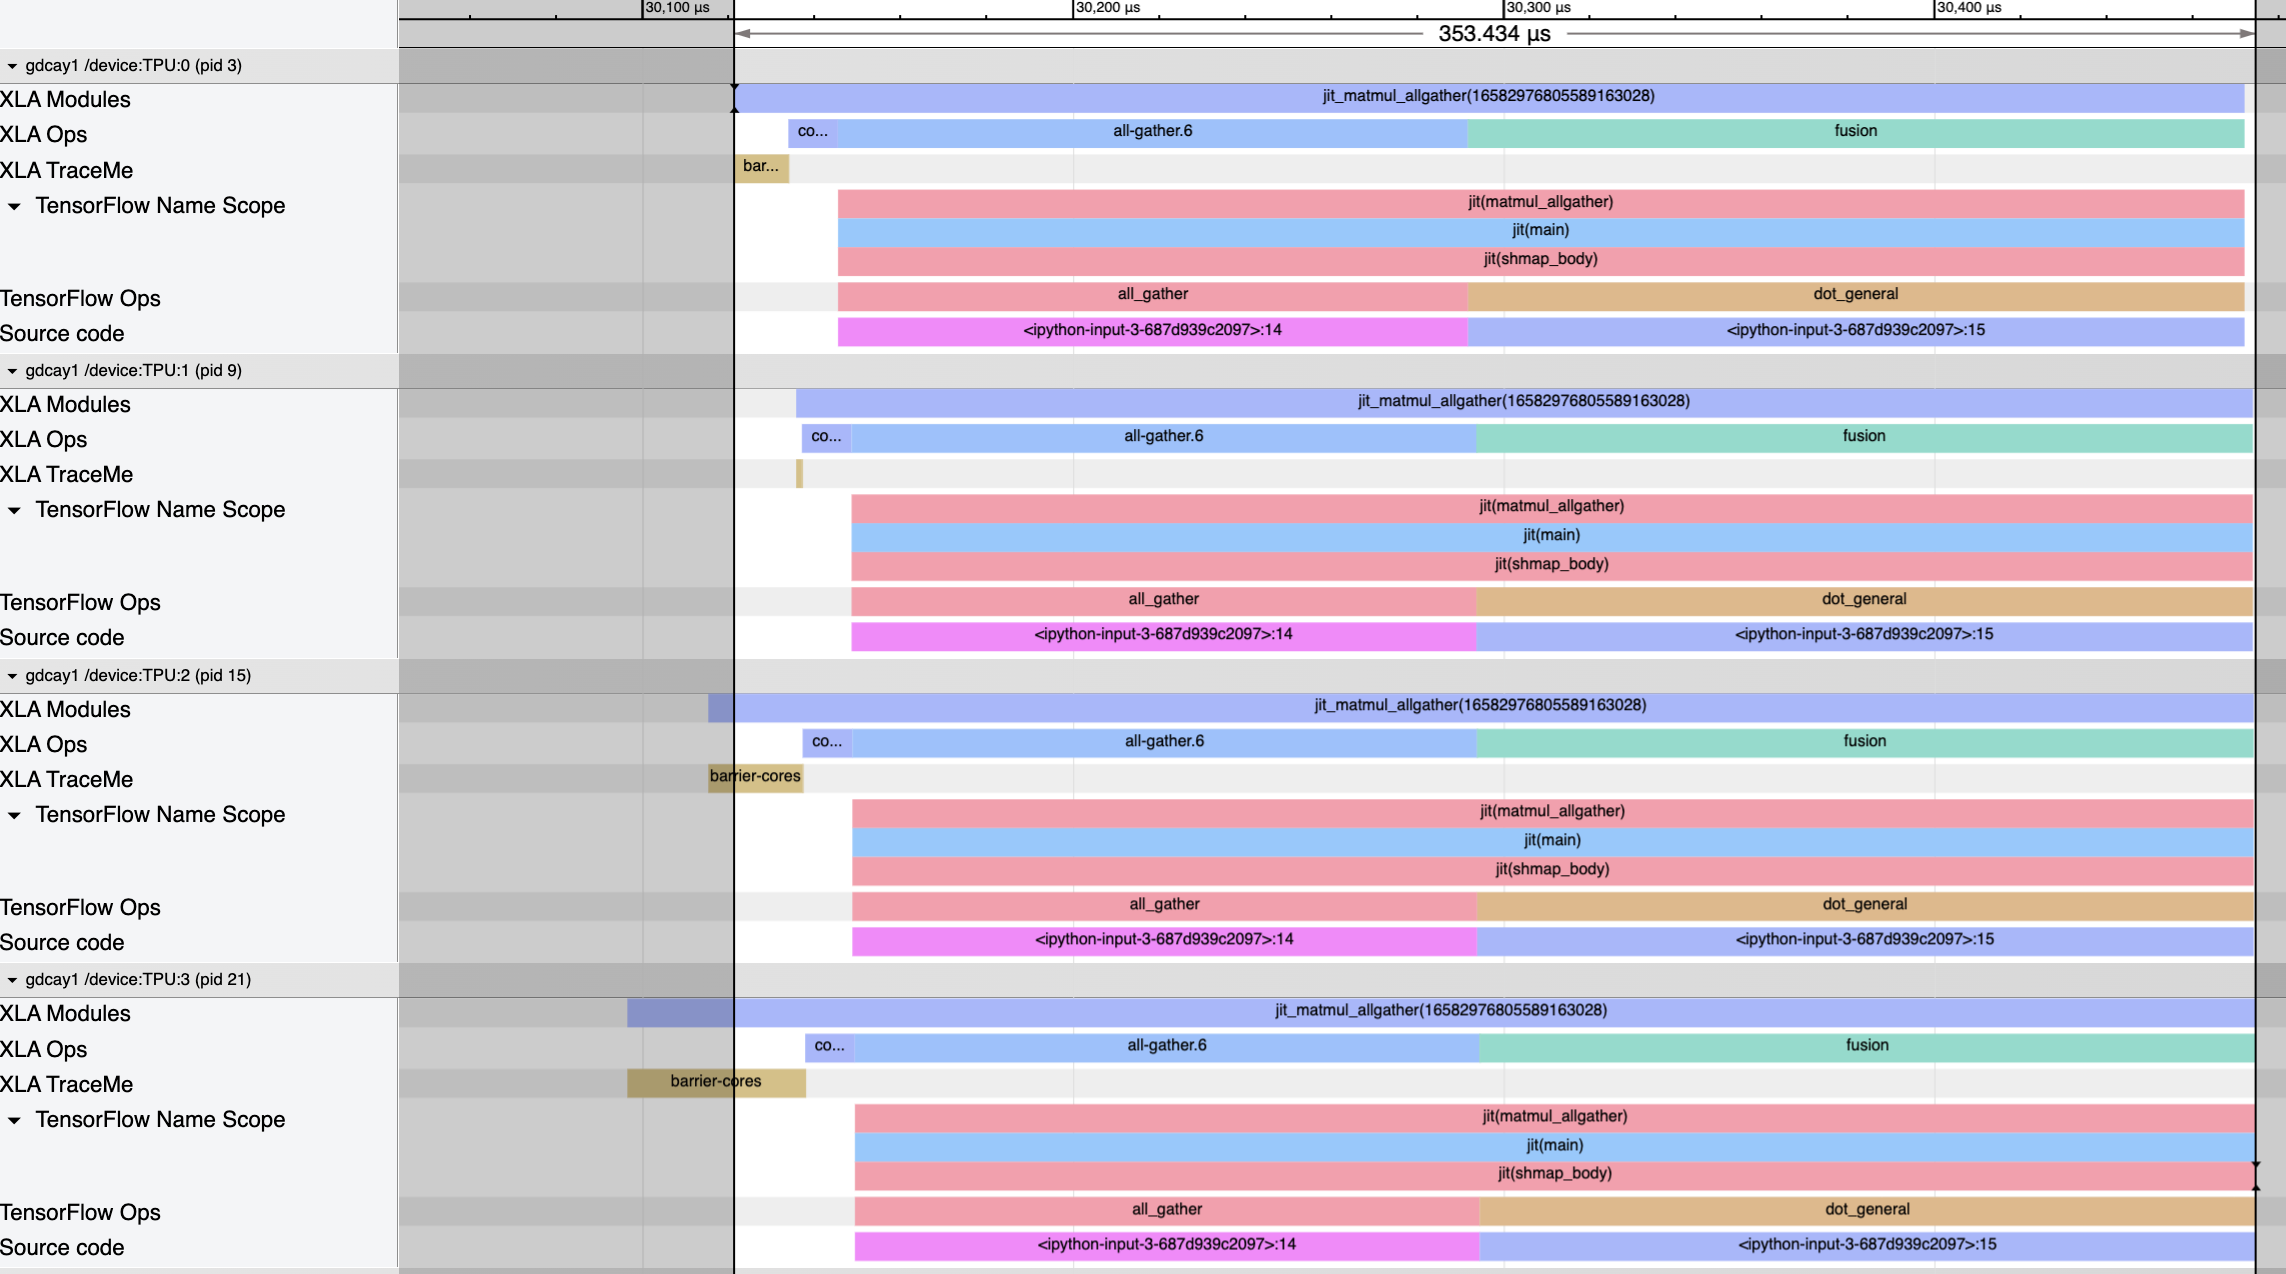

We can get compute/communication overlap if instead of calling `all_gather` we
basically inline our above implementation of `all_gather` in terms of
`ppermute`, then interleave steps of the gather permutation with local matrix
multiplies:


In [ ]:
@jax.jit
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_allgather_overlapped(lhs_block, rhs_block):
  size = jax.lax.psum(1, 'i')
  idx = jax.lax.axis_index('i')
  shift = partial(jax.lax.ppermute, axis_name='i',
                  perm=[(i, (i + 1) % size) for i in range(size)])

  B = lhs_block.shape[1] // size
  lhs_blocks = lambda i: lax.dynamic_slice_in_dim(lhs_block, i * B, B, 1)

  out_block = lhs_blocks(idx) @ rhs_block
  for i in range(1, size):
    rhs_block = shift(rhs_block)
    out_block += lhs_blocks((idx - i) % size) @ rhs_block
  return out_block


In [ ]:
out = matmul_allgather_overlapped(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))


这个实现允许通信和计算之间的重叠，并且避免了将大量中间数据聚集到每个设备上。但在TPU上，它只使用了一半的互连带宽，因为仅在环的一个方向上进行置换。要实现双向置换，我们只需将块分成两半，并在两个方向上各发送一半：


In [ ]:
@jax.jit
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_allgather_overlapped_bidi(lhs_block, rhs_block):
  size = jax.lax.psum(1, 'i')
  idx = jax.lax.axis_index('i')
  shift_up = partial(jax.lax.ppermute, axis_name='i',
                     perm=[(i, (i + 1) % size) for i in range(size)])
  shift_dn = partial(jax.lax.ppermute, axis_name='i',
                     perm=[(i, (i - 1) % size) for i in range(size)])

  B = lhs_block.shape[1] // size // 2  # 半尺寸块
  lhs_blocks = lambda i, hi: lax.dynamic_slice_in_dim(lhs_block, (2*i+hi) * B, B, 1)

  rhs_block_lo, rhs_block_hi = jnp.split(rhs_block, 2, axis=0)
  out_block  = lhs_blocks(idx, 0) @ rhs_block_lo
  out_block += lhs_blocks(idx, 1) @ rhs_block_hi
  for i in range(1, size):
    rhs_block_lo = shift_up(rhs_block_lo)
    rhs_block_hi = shift_dn(rhs_block_hi)
    out_block += lhs_blocks((idx - i) % size, 0) @ rhs_block_lo
    out_block += lhs_blocks((idx + i) % size, 1) @ rhs_block_hi
  return out_block


In [ ]:
out = matmul_allgather_overlapped_bidi(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))


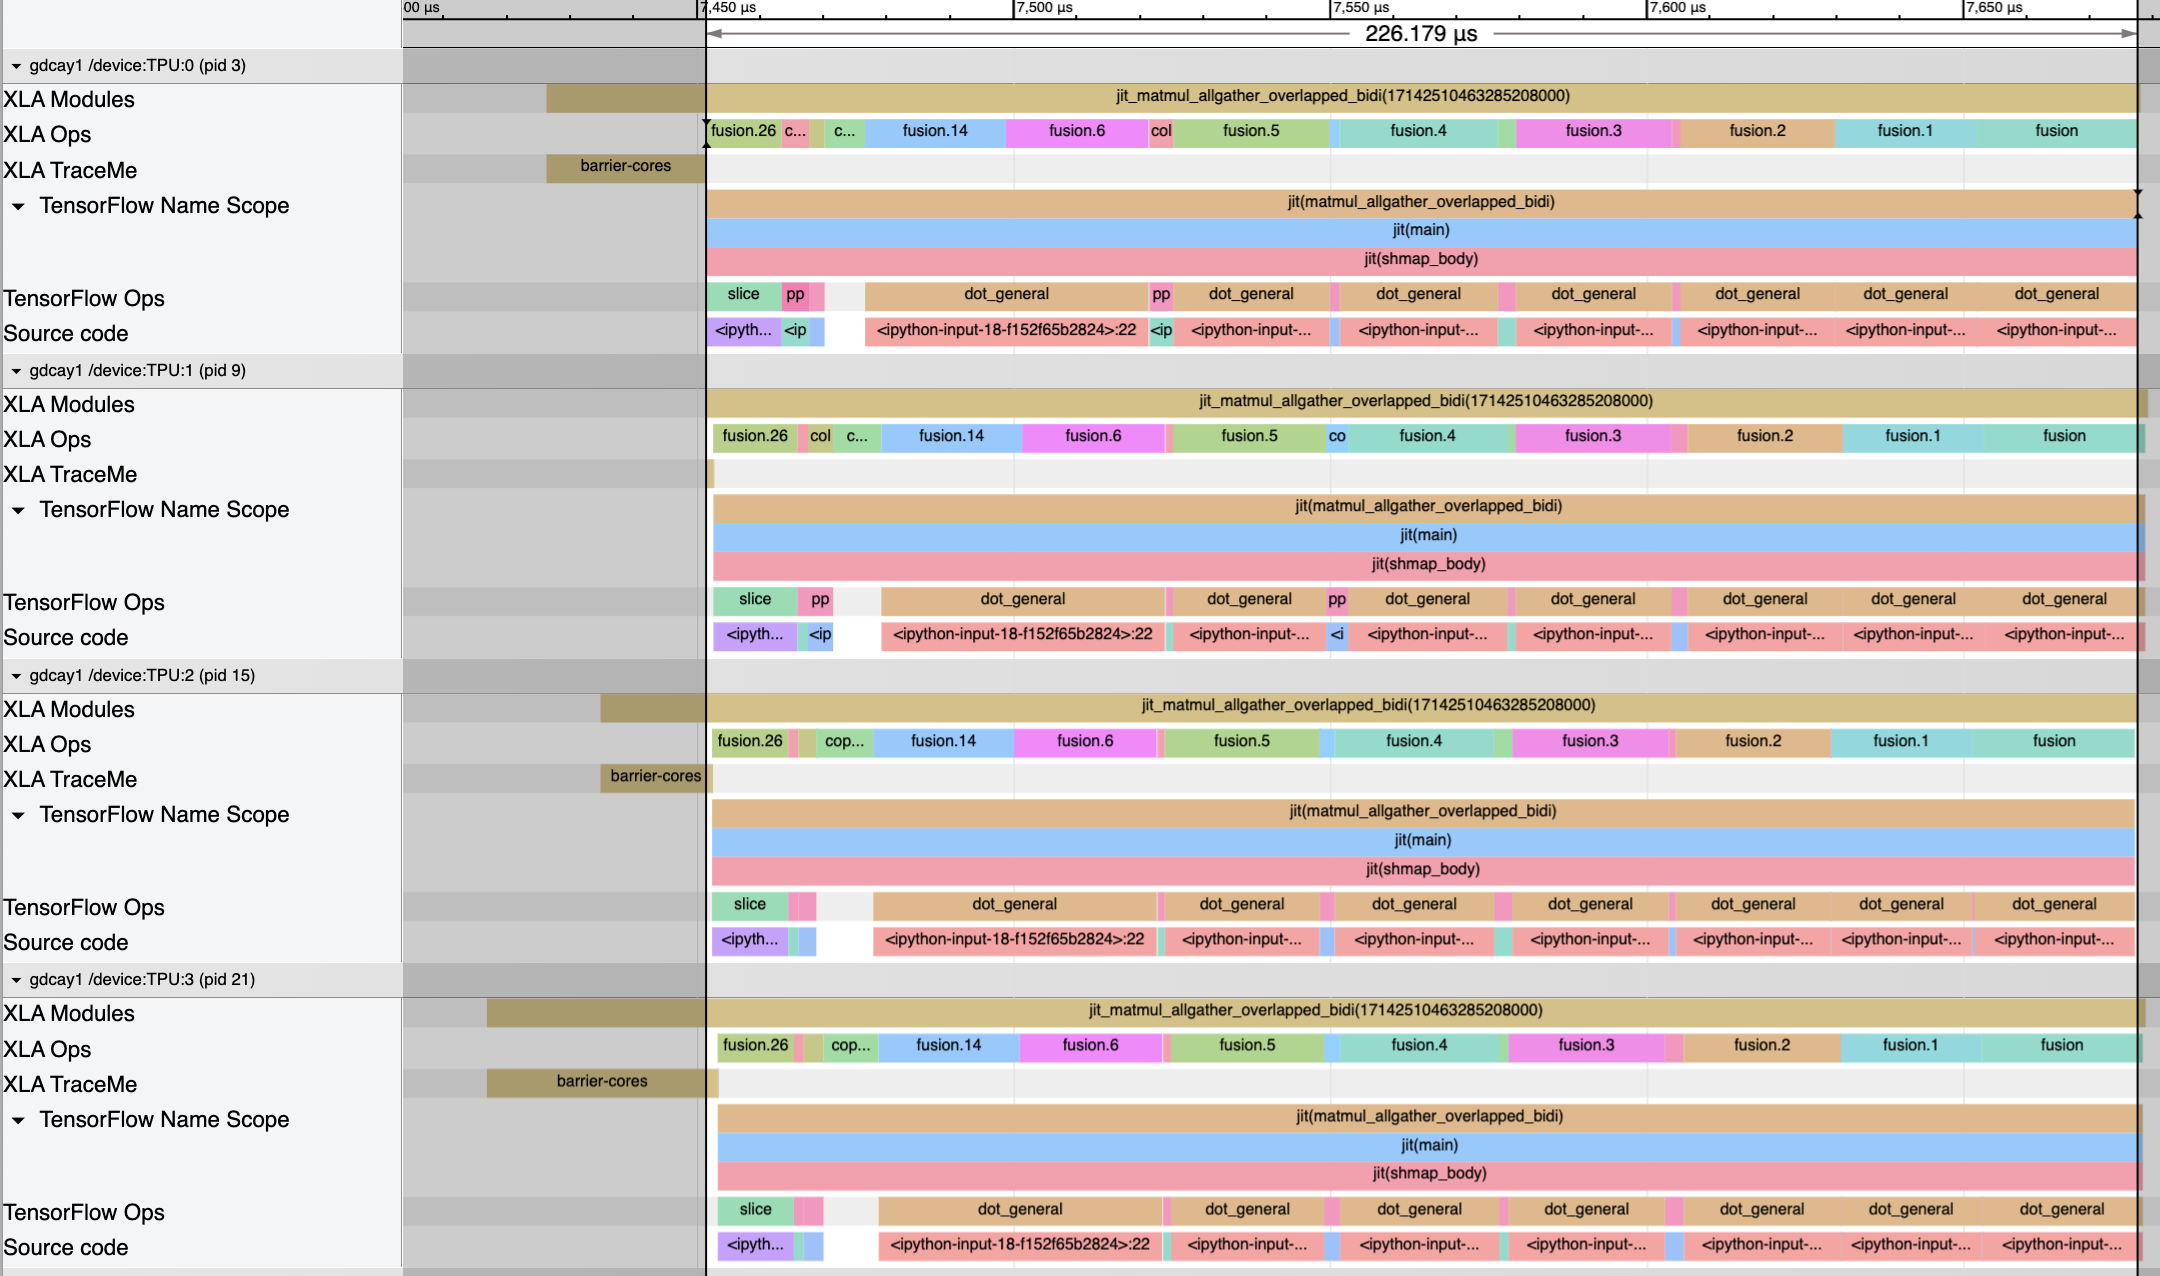

In practice, to reduce compile times we would probably roll this into a
`jax.lax.fori_loop`. We might also have additional axes of parallelism
involved.

#### Example 2: `psum_scatter` the result

Another sharding we might start with has both `lhs` and `rhs` sharded along
their contracting dimensions, with the output sharded like `rhs` again:


In [ ]:
lhs_spec = P(None, 'i')
lhs = device_put(lhs, lhs_spec)

rhs_spec = P('i', None)
rhs = device_put(rhs, rhs_spec)


在这里，我们可以使用 `reduce_scatter` 来对分片进行收缩求和：


In [ ]:
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_psumscatter(lhs_block, rhs_block):
  out_summand = lhs_block @ rhs_block
  return jax.lax.psum_scatter(out_summand, 'i', tiled=True)

out = matmul_psumscatter(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))


但是分散通信必须等到整个本地矩阵乘法完成后才能开始。为了实现通信和计算的重叠，我们可以将 `psum_scatter` 的实现嵌入到 `ppermute` 中，然后将通信步骤与本地矩阵乘法交错进行：


In [ ]:
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_psumscatter_overlapped(lhs_block, rhs_block):
  size = jax.lax.psum(1, 'i')
  idx = jax.lax.axis_index('i')
  shift = partial(jax.lax.ppermute, axis_name='i',
                  perm=[(i, (i - 1) % size) for i in range(size)])
  lhs_block = lhs_block.reshape(size, -1, lhs_block.shape[1])  # 分割第一轴

  out_summand = lhs_block[(idx + 1) % size] @ rhs_block
  for i in range(1, size):
    out_summand = shift(out_summand)
    out_summand += lhs_block[(idx + i + 1) % size] @ rhs_block
  return out_summand


In [ ]:
out = matmul_psumscatter_overlapped(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))


与之前的示例一样，为了充分利用TPU上的互连，我们将运行一个双向版本：


In [ ]:
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_psumscatter_overlapped_bidi(lhs_block, rhs_block):
  size = jax.lax.psum(1, 'i')
  idx = jax.lax.axis_index('i')
  shift_up = partial(jax.lax.ppermute, axis_name='i',
                     perm=[(i, (i + 1) % size) for i in range(size)])
  shift_dn = partial(jax.lax.ppermute, axis_name='i',
                     perm=[(i, (i - 1) % size) for i in range(size)])

  B = lhs_block.shape[0] // size // 2  # 半尺寸块
  lhs_blocks = lambda i, hi: lax.dynamic_slice_in_dim(lhs_block, (2*i+hi) * B, B, 0)

  out_summand_lo = lhs_blocks((idx - 1) % size, 0) @ rhs_block
  out_summand_hi = lhs_blocks((idx + 1) % size, 1) @ rhs_block
  for i in range(1, size):
    out_summand_lo = shift_up(out_summand_lo)
    out_summand_hi = shift_dn(out_summand_hi)
    out_summand_lo += lhs_blocks((idx - i - 1) % size, 0) @ rhs_block
    out_summand_hi += lhs_blocks((idx + i + 1) % size, 1) @ rhs_block
  return jnp.concatenate([out_summand_lo, out_summand_hi])


In [ ]:
out = matmul_psumscatter_overlapped_bidi(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))


### 神经网络

我们可以使用 `shard_map` 来并行化神经网络中的计算，无论是单独使用还是与 `jax.jit` 中的自动分区结合使用。本节包含基于这个玩具神经网络和随机数据的一些示例：


In [ ]:
import jax
import jax.numpy as jnp

def predict(params, inputs):
  for W, b in params:
    outputs = jnp.dot(inputs, W) + b
    inputs = jax.nn.relu(outputs)
  return outputs

def loss(params, batch):
  inputs, targets = batch
  predictions = predict(params, inputs)
  return jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))


In [ ]:
def init_layer(key, n_in, n_out):
  k1, k2 = jax.random.split(key)
  W = jax.random.normal(k1, (n_in, n_out)) / jnp.sqrt(n_in)
  b = jax.random.normal(k2, (n_out,))
  return W, b

def init(key, layer_sizes, batch_size):
  key, *keys = jax.random.split(key, len(layer_sizes))
  params = list(map(init_layer, keys, layer_sizes[:-1], layer_sizes[1:]))

  key, *keys = jax.random.split(key, 3)
  inputs = jax.random.normal(keys[0], (batch_size, layer_sizes[0]))
  targets = jax.random.normal(keys[1], (batch_size, layer_sizes[-1]))

  return params, (inputs, targets)


In [ ]:
layer_sizes = [784, 128, 128, 128, 128, 128, 8]
batch_size = 32

params, batch = init(jax.random.key(0), layer_sizes, batch_size)


将这些示例与“[分布式数组和自动分区](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html)”文档中的纯自动分区示例进行比较。在那些自动分区示例中，我们不需要编辑模型函数以使用不同的并行化策略，而在 `shard_map` 中，我们通常需要这样做。

#### 8-way 批量数据并行

最简单的多设备并行策略是将输入和目标的批量分片到多个设备上，参数在这些设备上进行复制，并将模型并行应用于这些数据分片。要评估总体损失，设备只需在最后进行标量大小的全归约和求和通信。（要评估损失的梯度，设备必须在反向传播中执行参数梯度的全归约求和。）


In [ ]:
from functools import partial

from jax.sharding import NamedSharding, Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
from jax.experimental import mesh_utils

devices = mesh_utils.create_device_mesh((8,))

# 在所有设备上复制初始参数，并在设备间分片数据批次
mesh = Mesh(devices, ('batch',))
batch = jax.device_put(batch, NamedSharding(mesh, P('batch')))
params = jax.device_put(params, NamedSharding(mesh, P()))

# 调整损失函数以跨设备求和
def loss_dp(params, batch):
  @partial(shard_map, mesh=mesh, in_specs=P('batch', None), out_specs=P())
  def loss_spmd(local_batch):
    inputs, targets = local_batch
    predictions = predict(params, inputs)  # use reference 'predict`
    local_loss = jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))
    return jax.lax.pmean(local_loss, 'batch')
  return loss_spmd(batch)


我们可以检查损失及其梯度是否与参考（基础）模型匹配：


In [ ]:
print(jax.jit(loss)(params, batch))
print(jax.jit(loss_dp)(params, batch))


In [ ]:
def allclose(a, b):
  return tree_all(tree_map(partial(jnp.allclose, atol=1e-2, rtol=1e-2), a, b))

print(allclose(jax.jit(jax.grad(loss))(params, batch),
               jax.jit(jax.grad(loss_dp))(params, batch)))


我们可以打印编译器的中间表示（IR），以检查梯度计算，并验证集合的全归约求和操作发生在我们预期的地方：在前向传播结束时计算损失值，以及在反向传播中计算总参数梯度。

#### 8路全分片数据并行（FSDP）

另一种策略是将参数额外分片到设备上，在需要完整值进行 `jnp.dot` 或偏置相加时进行全收集。由于我们在本地设备内存中一次只有一个完整的参数，而不是像前面的数据并行示例那样将所有参数保留在所有设备内存中，我们释放出了大量内存，可以用于更大模型或更大批量的大小。而且由于XLA会重叠计算和设备间通信，实际的时钟时间并不会受到影响。

所以现在我们需要在两个地方使用集合操作：模型预测函数 `predict` 需要在使用参数之前进行全收集，并且像数据并行情况一样，损失函数需要将本地损失求和，以计算总损失。

我们还需要另一个要素：我们不想在反向传播中存储从前向传播获得的全收集参数。相反，我们希望在反向传播时再次进行收集。我们可以通过使用 `jax.remat` 和 [自定义政策](https://jax.readthedocs.io/en/latest/notebooks/autodiff_remat.html#custom-policies-for-what-s-saveable)（或 `custom_vjp`）来表达这一点，尽管XLA通常会自动进行这个重物化。

这种通用的 [FSDP 方法](https://engineering.fb.com/2021/07/15/open-source/fsdp/) 类似于 [权重更新分片（WUS）](https://arxiv.org/abs/2004.13336) 和 [ZeRO-3](https://arxiv.org/abs/1910.02054)。


In [ ]:
# 将数据分片批处理*及参数*分布到各设备上
mesh = Mesh(devices, ('batch',))
batch = jax.device_put(batch, NamedSharding(mesh, P('batch')))
params = jax.device_put(params, NamedSharding(mesh, P('batch')))

# 调整预测函数，以便在使用权重之前收集它们，
# 并在反向传播时重新收集这些值（而不是保存它们）
@partial(jax.remat, policy=lambda op, *_, **__: str(op) != 'all_gather')
def predict_fsdp(params_frag, inputs):
  for W_frag, b_frag in params_frag:
    W = jax.lax.all_gather(W_frag, 'batch', tiled=True)
    b = jax.lax.all_gather(b_frag, 'batch', tiled=True)
    outputs = jnp.dot(inputs, W) + b
    inputs = jax.nn.relu(outputs)
  return outputs

def loss_fsdp(params, batch):
  @partial(shard_map, mesh=mesh, in_specs=P('batch'), out_specs=P())
  def loss_spmd(local_params, local_batch):
    inputs, targets = local_batch
    predictions = predict_fsdp(local_params, inputs)
    local_loss = jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))
    return jax.lax.pmean(local_loss, 'batch')
  return loss_spmd(params, batch)


我们可以再次检查损失及其梯度是否与参考模型匹配：


In [ ]:
print(jax.jit(loss)(params, batch))
print(jax.jit(loss_fsdp)(params, batch))

print(allclose(jax.jit(jax.grad(loss))(params, batch),
               jax.jit(jax.grad(loss_fsdp))(params, batch)))


#### 8路张量并行 (TP)

通常我们不会单独使用张量模型并行，但将其孤立地观察是对并行矩阵乘法的一个很好的热身。这也是一个在库函数中使用 `shard_map` 的很好的例子，该函数在一个更大的 `jit` 基础的计算中被调用。

并行化的思路是我们将数据/激活在其特征轴上进行分片（而不是在其批量轴上），并且我们将权重矩阵在其输入特征轴上进行类似的分片（偏置在其特征轴上进行分片）。然后，为了执行并行矩阵乘法，我们将执行局部矩阵乘法，随后进行 `psum_scatter` 以汇总局部结果并高效地分散结果的分片。


In [ ]:
devices = mesh_utils.create_device_mesh((8,))
mesh = Mesh(devices, ('feats',))

batch = jax.device_put(batch, NamedSharding(mesh, P(None, 'feats')))
params = jax.device_put(params, NamedSharding(mesh, P('feats')))

def predict_tp(params, inputs):
  for W, b in params:
    outputs = gemm_tp(inputs, W, b)
    inputs = jax.nn.relu(outputs)
  return outputs

@partial(shard_map, mesh=mesh,
         in_specs=(P(None, 'feats'), P('feats', None), P('feats')),
         out_specs=P(None, 'feats'))
def gemm_tp(inputs, W, b):
  block_result = jnp.dot(inputs, W)
  return jax.lax.psum_scatter(block_result, 'feats',
                              scatter_dimension=1, tiled=True) + b

def loss_tp(params, batch):
  inputs, targets = batch
  predictions = predict_tp(params, inputs)
  return jnp.mean(jnp.sum((predictions - targets) ** 2, axis=-1))  # 注意：此处为占位符文本！


#### FSDP + TP，顶层使用 `shard_map`

我们可以将这些策略组合在一起，利用多个并行轴。


In [ ]:
devices = mesh_utils.create_device_mesh((4, 2))
mesh = Mesh(devices, ('batch', 'feats'))

batch_ = jax.device_put(batch, NamedSharding(mesh, P('batch', 'feats')))
params_ = jax.device_put(params, NamedSharding(mesh, P(('batch', 'feats'))))

# 与之前的predict_fsdp定义基本相同，只是我们调用了gemm_tp。
@partial(jax.remat, policy=lambda op, *_, **__: str(op) != 'all_gather')
def predict_fsdp_tp(params_frag, inputs):
  for W_frag, b_frag in params_frag:
    W = jax.lax.all_gather(W_frag, 'batch', tiled=True)
    b = jax.lax.all_gather(b_frag, 'batch', tiled=True)
    block_result = jnp.dot(inputs, W)
    outputs = jax.lax.psum_scatter(block_result, 'feats',
                                   scatter_dimension=1, tiled=True) + b
    inputs = jax.nn.relu(outputs)
  return outputs

@partial(shard_map, mesh=mesh,
         in_specs=(P(('feats', 'batch')), P('batch', 'feats')),
         out_specs=P())
def loss_fsdp_tp(local_params, local_batch):
  inputs, targets = local_batch
  predictions = predict_fsdp_tp(local_params, inputs)
  sq_err = jax.lax.psum(jnp.sum((predictions - targets)**2, axis=-1), 'feats')
  return jax.lax.pmean(jnp.mean(sq_err), 'batch')


注意到我们需要进行 _两个_ 集体归约：一个是对 `'feats'`，另一个是对 `'batch'`。在纯 TP 示例中，我们没有显式地写出 `'feats'` 的归约，因为我们只在 `gemm_tp` 中使用了 `shard_map`；在调用者 `loss_tp` 中，编译器自动将我们对 `jnp.sum` 的使用转换为必要的 `psum`，这是基于由 `predict_tp` 返回的分片结果。


In [ ]:
print(jax.jit(loss)(params, batch))
print(jax.jit(loss_fsdp_tp)(params_, batch_))

print(allclose(jax.jit(jax.grad(loss))(params, batch),
               jax.jit(jax.grad(loss_fsdp_tp))(params, batch)))


#### SPMD 管道并行性 (PP)

通过管道并行性，我们旨在对网络中不同深度层的评估进行并行化。例如，一个设备可能会计算第一层的应用，而另一个设备则计算第二层的应用；当它们完成时，第一个设备将其结果传递给第二个设备，而第二个设备将其结果传递给负责第三层的设备，流程重复进行。通常，管道阶段的数量可能与层的数量不同，因为每个阶段可能负责多个层。

通过 SPMD 管道，我们利用了网络中大多数层应用计算的事实，只是参数值不同。特别是，我们可以将所有参数堆叠在一起，除了第一层和最后一层的参数，然后使用 `shard_map` 在这些层参数的块上进行映射，每个参数块对应一个管道阶段。然后我们使用 `jax.lax.ppermute` collective 将数据向下移动到并行管道中。

这种特定的管道策略本质上是 [GPipe 策略](https://arxiv.org/abs/1811.06965)。它有几种变体，以及相当不同的策略，具体使用哪种取决于阶段之间的网络速度和批次大小。但在本教程中，我们将重点关注一种策略。

首先，我们选择一些管道参数：


In [ ]:
L = len(params) - 2        # 层数，不包括第一层和最后一层
N = batch_size             # 批量大小
F = params[0][0].shape[1]  # 数字特性

# 选择一些管道参数
S = 2      # 阶段数
B = 8      # 每个微批次的规模
assert L % S == 0, "S (number of stages) must divide L (number of inner layers)"

# 计算一些有用的量
M, ragged = divmod(N, B)  # M 是微批次的数量
assert not ragged, "B (size of each microbatch) must divide total batch size"
K, ragged = divmod(M, S)  # K 表示每个阶段中的微批次数量
assert not ragged, "S (number of stages) must divide number of microbatches"
print(f'{S} stages, {L // S} layer(s) per stage, {L} pipelined layers total')
print(f'{B} examples per microbatch, {M} microbatches total')


In [ ]:
mesh = Mesh(jax.devices()[:S], ('stages',))

def predict_pp(params, inputs):
  (W_first, b_first), inner_params, (W_last, b_last) = params
  inputs = jax.nn.relu(jnp.dot(inputs, W_first) + b_first)
  inputs = spmd_pipeline(lambda Wb, x: jax.nn.relu(x @ Wb[0] + Wb[1]),
                        inner_params, inputs)
  outputs = jnp.dot(inputs, W_last) + b_last
  return outputs

@partial(shard_map, mesh=mesh, in_specs=((P(), P('stages'), P()), P('stages')),
         out_specs=P())
def loss_pp(params, batch):
  inputs, targets = batch
  predictions = predict_pp(params, inputs.reshape(K, B, -1)).reshape(K * B, -1)
  local_loss = jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))
  return jax.lax.pmean(local_loss, 'stages')


In [ ]:
def spmd_pipeline(fn, stage_params, inputs):
  stage = jax.lax.axis_index('stages')
  outputs = jnp.zeros_like(inputs) * jnp.nan
  state = jnp.zeros((L // S, B, F)) * jnp.nan
  for i in range(M+L-1):
    state = state.at[0].set(jnp.where(stage == 0, inputs[i % K], state[0]))
    state = jax.vmap(fn)(stage_params, state)
    outputs = outputs.at[(i-L+1) % K].set(jnp.where(stage == S-1, state[-1], outputs[(i-L+1) % K]))
    state, inputs, outputs = shift(i, state, inputs, outputs)
  outputs = jax.lax.ppermute(outputs, 'stages', [(i, (i+1) % S) for i in range(S)])
  return outputs

def shift(i, state, inputs, outputs):
  sh = lambda x, d: jax.lax.ppermute(x, 'stages', [(i, (i+d) % S) for i in range(S)])
  state = jnp.roll(state, +1, axis=0).at[0].set(sh(state[-1], +1))
  if (i % K) == (-1 % K):
    inputs = sh(inputs, +1)
  if ((i-L+1) % K) == (-1 % K):
    outputs = sh(outputs, +1)
  return state, inputs, outputs


In [ ]:
first_params, *inner_params, last_params = params
Ws, bs = zip(*inner_params)
params_stacked = jnp.stack(Ws), jnp.stack(bs)
first_params = jax.device_put(first_params, NamedSharding(mesh, P()))
params_stacked = jax.device_put(params_stacked, NamedSharding(mesh, P('stages')))
last_params = jax.device_put(last_params, NamedSharding(mesh, P()))
params_ = first_params, params_stacked, last_params

batch_ = jax.device_put(batch, NamedSharding(mesh, P('stages')))


In [ ]:
print(jax.jit(loss)(params, batch))
print(jax.jit(loss_pp)(params_, batch_))


In [ ]:
_ = jax.jit(jax.grad(loss_pp))(params_, batch_)   # 不要崩溃
